In [1]:
#importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from scipy import signal


In [2]:
#please change the value to access subject details. eg: '02' , '08', '20'
num ='20'

In [3]:
time_logs = pd.read_excel('time_logs.xlsx')
# /Users/karthikningala/CE888-DATA SCIENCE AND DECISION MAKING/Time_logs.xlsx
time_logs.head()

,S. ID.,Start Time,End Time,Session ID,Consent,Unnamed: 5,Baseline/Questionniare,Unnamed: 7,Stroop Test,Unnamed: 9,...,Hyperventilation,Unnamed: 17,Relax.2,Unnamed: 19,Questionniare,Unnamed: 21,Relax/Baseline,Unnamed: 23,Unnamed: 24,Date
0,NaN,NaN,NaN,NaN,Start,End,Start,End,Start,End,...,Start,End,Start,End,Start,End,Start,End,NaN,NaT
1,S01,09:22:00,10:22:00,1445405.0,09:22:00,09:27:00,09:39:00,09:43:00,09:29:00,09:34:00,...,10:00:00,10:02:00,10:02:00,10:07:00,10:08:00,10:12:00,10:12:00,10:22:00,Day 1,2022-02-07
2,S02,09:48:00,10:51:00,1445449.0,09:48:00,09:50:00,09:52:00,10:02:00,10:03:00,10:08:00,...,10:29:00,10:31:00,10:31:00,10:36:00,10:36:00,10:41:00,10:41:00,10:51:00,Day 1,2022-02-07
3,S03,10:50:00,11:50:00,1445450.0,10:50:00,10:53:00,10:55:00,11:02:00,11:04:00,11:09:00,...,11:28:00,11:30:00,11:30:00,11:35:00,11:35:00,11:40:00,11:40:00,11:50:00,Day 1,2022-02-07
4,S04,11:25:00,12:28:00,1445452.0,11:25:00,11:30:00,11:30:00,11:40:00,11:40:00,11:45:00,...,12:05:00,12:07:00,12:07:00,12:12:00,12:12:00,12:18:00,12:18:00,12:28:00,Day 1,2022-02-07


In [4]:
#dividing the time logs into intervals
s=time_logs.loc[time_logs['S. ID.']==f'S{num}']
stroop_test = s['Stroop Test']
relax1 = s['Relax']
interview=s['Interview']
relax2=s['Relax.1']
hyperventilation = s['Hyperventilation']
relax3 = s['Relax.2']

list_of_test = [stroop_test,relax1,interview,relax2,hyperventilation,relax3]
time_logs = []
stroop_test.astype(str).values[0]
for i in list_of_test:
    a = i.astype(str)
    a= a.values[0]
    print(a)
    time_logs.append(a)

10:01:00
10:07:00
10:13:00
10:23:00
10:27:00
10:29:00


In [5]:
time_logs = time_logs[:6]

READING THE SUBJECTS HEART RATE VAUES

In [6]:
hrate = pd.read_csv(f'https://raw.githubusercontent.com/italha-d/Stress-Predict-Dataset/main/Raw_data/S{num}/HR.csv',header=None)
hrate.head()

,0
0,1.646042e+09
1,1.000000e+00
2,6.100000e+01
3,6.800000e+01
4,8.167000e+01


DATA ANALYSIS

In [7]:
hrate[2:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3386 entries, 2 to 3387
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       3386 non-null   float64
dtypes: float64(1)
memory usage: 26.6 KB


In [8]:
#summary of heart rate excluding the first two rows
hrate[2:].describe()

,0
count,3386.000000
mean,83.750712
std,12.772540
min,61.000000
25%,76.950000
50%,81.870000
75%,86.580000
max,140.680000


DATA PROCESSING

In [9]:
#initial time_stamp
hr_initital_time = int(hrate[0][0])
#creating a new pandas dataframe
hr_combined_data = pd.DataFrame()
#adding the heart_rate values to the dataframe
hr_combined_data['heart_rate'] = hrate[2:]
#creating the time_stamp for the rest of the values
hr_combined_data['utc_time']= range(hr_initital_time,hr_initital_time+len(hr_combined_data['heart_rate']))
#resetting the index to start with 0
hr_combined_data= hr_combined_data.reset_index()
hr_combined_data=hr_combined_data.drop(columns='index')
#converting the UTC time to 24 hour format time
hr_time_stp = []
for i in  hr_combined_data['utc_time']:
    c = str(datetime.datetime.fromtimestamp(i).time())
    d = datetime.datetime.strptime(c, "%H:%M:%S")
    a =d.strftime("%I:%M:%S" )
    hr_time_stp.append(a)
    # hr_time_stp.append(f'{c.hour}:{c.minute}:{c.second}')
hr_combined_data['time'] = hr_time_stp

In [10]:
#combined data
hr_combined_data

,heart_rate,utc_time,time
0,61.00,1646041799,09:49:59
1,68.00,1646041800,09:50:00
2,81.67,1646041801,09:50:01
3,81.75,1646041802,09:50:02
4,82.00,1646041803,09:50:03
...,...,...,...
3381,88.38,1646045180,10:46:20
3382,88.27,1646045181,10:46:21
3383,88.12,1646045182,10:46:22
3384,87.97,1646045183,10:46:23


PLOTTING THE DATA

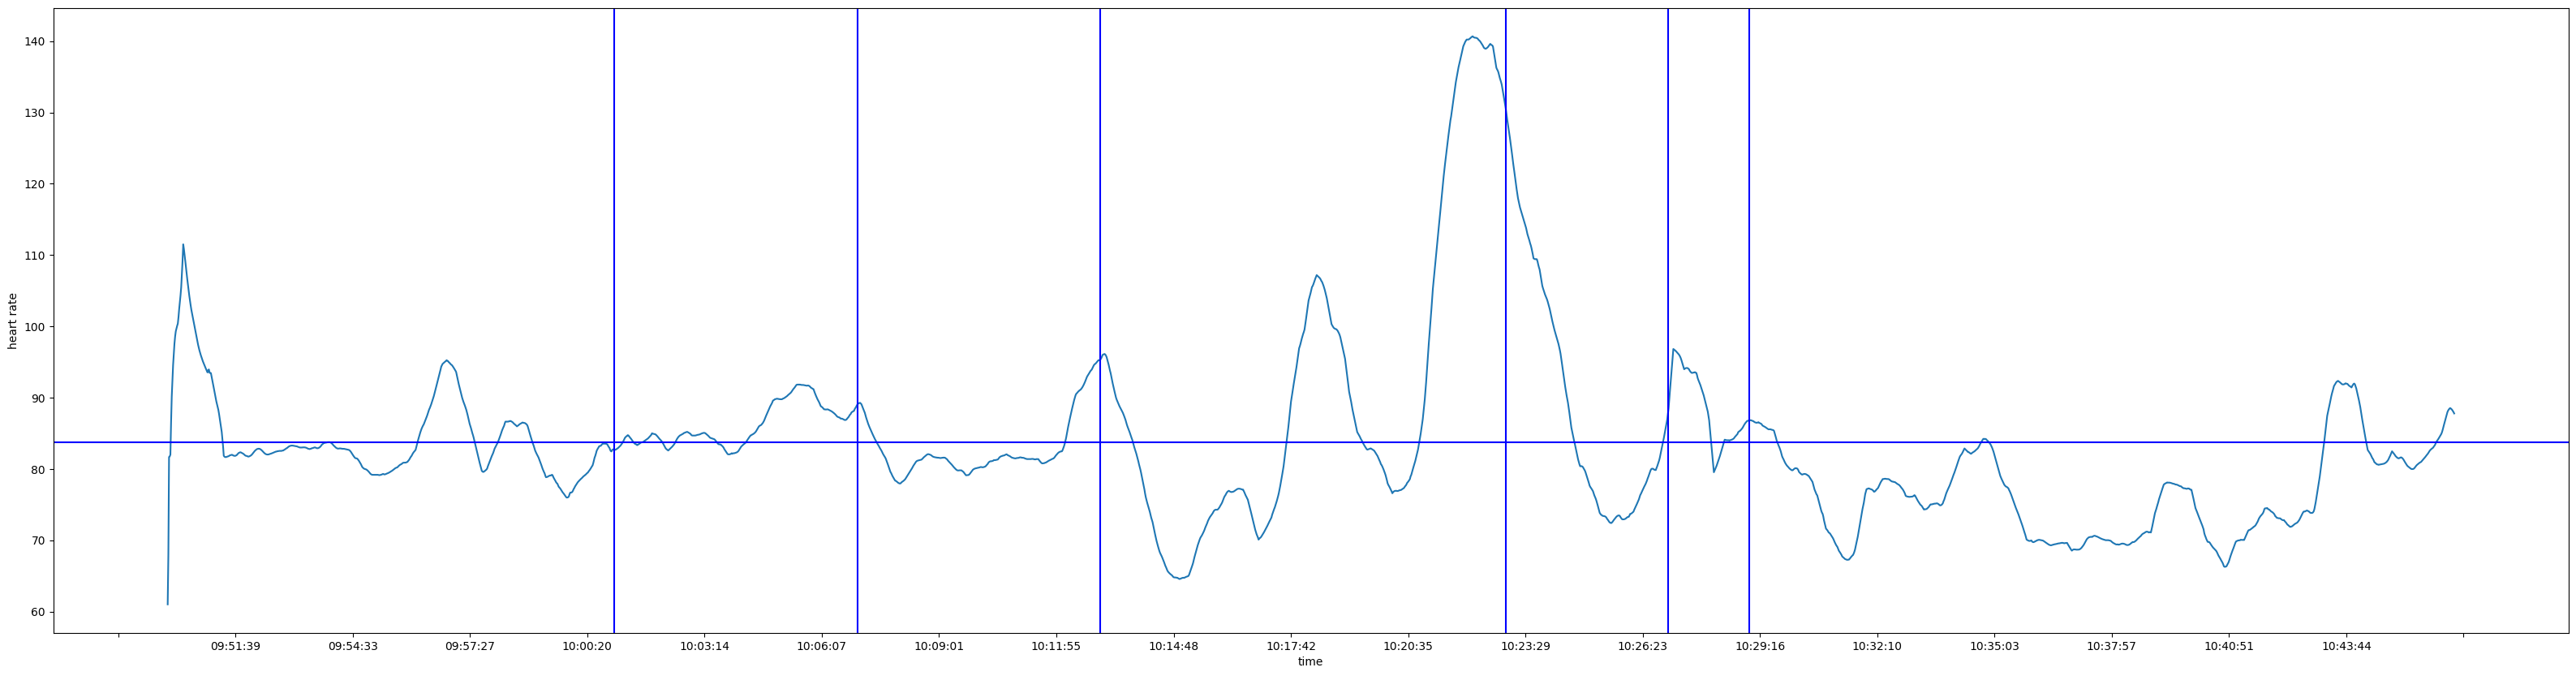

In [11]:
#plotting the heart rate 
fig, a_x = plt.subplots(figsize=(40, 10))
#paramaters 
y=hr_combined_data['heart_rate']
x=hr_combined_data['time']

#marking time intervals
time = mdates.MinuteLocator(interval=250000)
a_x.xaxis.set_major_locator(time) 
#plotting the graph
a_x.plot(x.astype(str), y)
# a_x.plot(rolling_mean)
# a_x.plot(rolling_mean2)
plt.xlabel('time')
plt.ylabel('heart rate')
for t in time_logs:
    plt.axvline(x = t, color = 'b', label = 'axvline - full height')
plt.axhline(y = y.mean(), color = 'b', label = 'axvline - full height')

#the vertical lines are the sessions and and the horizontal line respresents the mean value of the data.

READING THE SUBJECTS EDA VALUES

In [12]:
#reading the eda data
eda = pd.read_csv(f'https://raw.githubusercontent.com/italha-d/Stress-Predict-Dataset/main/Raw_data/S{num}/EDA.csv',header=None)
eda.head()
eda_data = eda[2:]

DATA ANALYSIS

In [13]:
eda_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13590 entries, 2 to 13591
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       13590 non-null  float64
dtypes: float64(1)
memory usage: 106.3 KB


In [14]:
eda_data.describe()

,0
count,13590.000000
mean,1.149627
std,0.256951
min,0.000000
25%,0.975528
50%,1.135595
75%,1.308674
max,2.872313


DATA PROCESSING

In [15]:
#filtering every 4th element as frequency is 4hz
count = 0
eda_4 = []
for i in eda_data[0]:
    if count % 4 == 0:
        eda_4.append(i)
    count +=1

In [16]:
#initital time stamp
eda_initital_time = int(eda[0][0])
#creating a pandas datafreame
eda_combined_data = pd.DataFrame()
#combining the filtered data to the dataframe
eda_combined_data['eda'] = eda_4
#creating time stamps for the rest of the data
eda_combined_data['utc_time']= range(eda_initital_time,eda_initital_time+len(eda_4))
eda_combined_data= eda_combined_data.reset_index()
eda_combined_data=eda_combined_data.drop(columns='index')
#converting UTC to 24 hr format
eda_time_stp = []
for i in  eda_combined_data['utc_time']:
    c = str(datetime.datetime.fromtimestamp(i).time())
    d = datetime.datetime.strptime(c, "%H:%M:%S")
    a =d.strftime("%I:%M:%S" )
    eda_time_stp.append(a)
    # eda_time_stp.append(f'{c.hour}:{c.minute}:{c.second}')
#combining the converted time to the dataframe
eda_combined_data['time'] = eda_time_stp

In [17]:
#combined data
eda_combined_data

,eda,utc_time,time
0,0.000000,1646041789,09:49:49
1,0.598648,1646041790,09:49:50
2,0.638370,1646041791,09:49:51
3,0.655027,1646041792,09:49:52
4,0.651183,1646041793,09:49:53
...,...,...,...
3393,1.808593,1646045182,10:46:22
3394,1.818843,1646045183,10:46:23
3395,1.643301,1646045184,10:46:24
3396,1.676615,1646045185,10:46:25


In [18]:
# eda_combined_data= find_index(eda_combined_data)

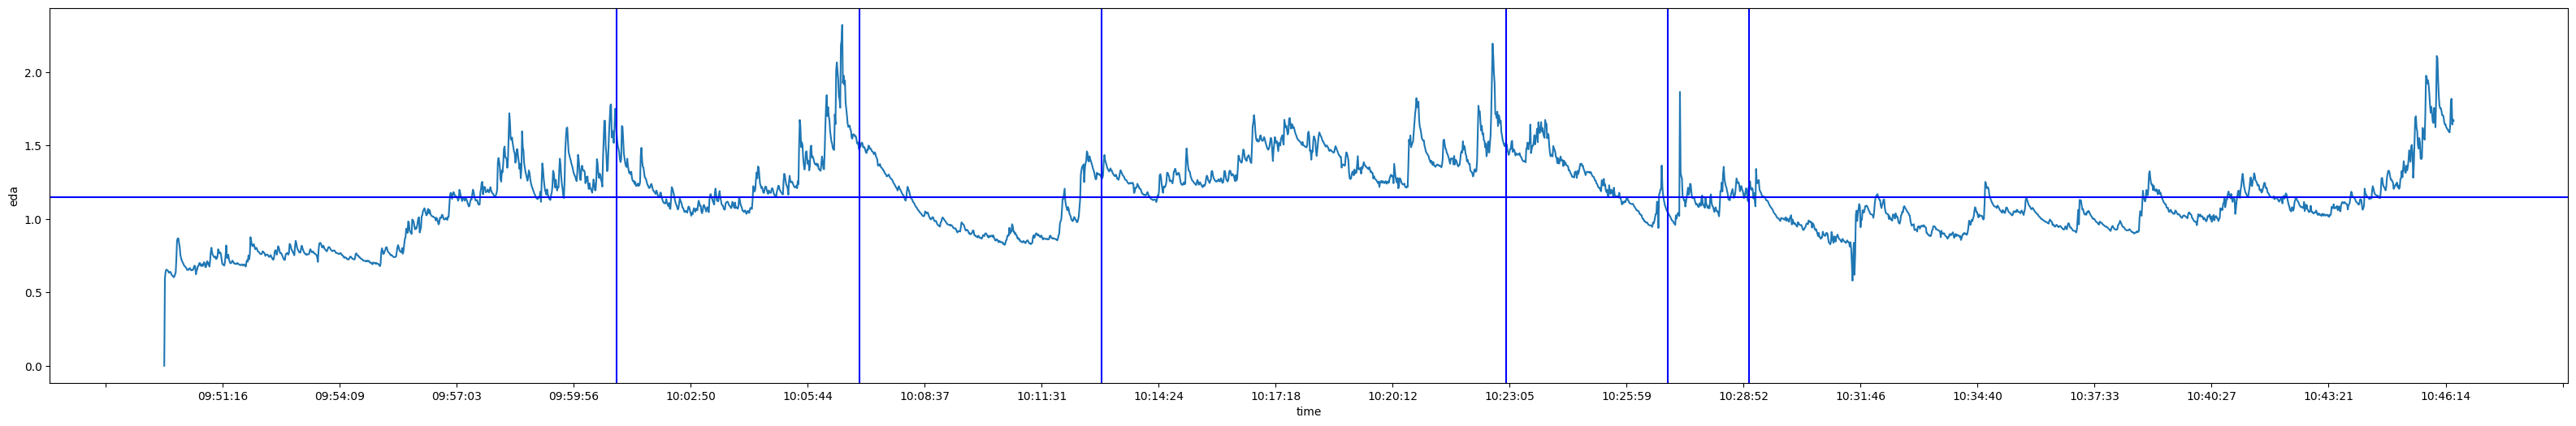

In [19]:
#plotting the eda values
fig, a_x = plt.subplots(figsize=(40, 6))
#parameters
y=eda_combined_data['eda']
x=eda_combined_data['time']

#marking time intervals
loc = mdates.MinuteLocator(interval=250000)
a_x.xaxis.set_major_locator(loc) # Locator for major axis only.
#plotting the graph
a_x.plot(x.astype(str), y)
plt.xlabel('time')
plt.ylabel('eda')
for t in time_logs:
    plt.axvline(x = t, color = 'b', label = 'axvline - full height')
plt.axhline(y = y.mean(), color = 'b', label = 'axvline - full height')
#the vertical lines are the sessions and and the horizontal line respresents the mean value of the data.

READING THE SUBJECTS ACC VALUES

In [20]:
#reading the ACC data
acc = pd.read_csv(f'https://raw.githubusercontent.com/italha-d/Stress-Predict-Dataset/main/Raw_data/S{num}/ACC.csv',header=None)
acc.head()

,0,1,2
0,1.646042e+09,1.646042e+09,1.646042e+09
1,3.200000e+01,3.200000e+01,3.200000e+01
2,7.000000e+00,-4.200000e+01,4.900000e+01
3,9.000000e+00,-3.900000e+01,5.300000e+01
4,2.300000e+01,-3.200000e+01,6.000000e+01


DATA ANALYSIS

In [21]:
acc[2:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108648 entries, 2 to 108649
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       108648 non-null  float64
 1   1       108648 non-null  float64
 2   2       108648 non-null  float64
dtypes: float64(3)
memory usage: 2.5 MB


In [22]:
acc[2:].describe()

,0,1,2
count,108648.000000,108648.000000,108648.000000
mean,-34.747497,-16.277456,30.534782
std,24.978882,19.774198,28.013807
min,-128.000000,-115.000000,-128.000000
25%,-55.000000,-31.000000,4.000000
50%,-37.000000,-9.000000,35.000000
75%,-15.000000,-4.000000,58.000000
max,127.000000,125.000000,127.000000


READING THE SUBJECTS IBI VALUES

In [23]:
#reading the IBI data
ibi = pd.read_csv(f'https://raw.githubusercontent.com/italha-d/Stress-Predict-Dataset/main/Raw_data/S{num}/IBI.csv',header=None)
ibi.head()

,0,1
0,1.646042e+09,IBI
1,3.173438e+01,0.687500
2,3.243750e+01,0.703125
3,3.315625e+01,0.718750
4,3.393750e+01,0.781250


DATA ANALYSIS

In [24]:
ibi[2:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199 entries, 2 to 1200
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1199 non-null   float64
 1   1       1199 non-null   object 
dtypes: float64(1), object(1)
memory usage: 18.9+ KB


In [25]:
ibi[1:].describe()

,0
count,1200.000000
mean,1296.796615
std,1033.562982
min,31.734375
25%,305.914062
50%,1144.781250
75%,2233.300781
max,3296.421875


DATA PROCESSING

In [26]:
#initital time stamp
ibi_initital_time = int(ibi[0][0])
#creating a pandas datafreame
ibi_combined_data = pd.DataFrame()
#combining the filtered data to the dataframe
ibi_combined_data['ibi'] = ibi[1][1:]
#creating time stamps for the rest of the data
ibi_combined_data['utc_time']= range(ibi_initital_time,ibi_initital_time+len(ibi[1][1:]))
ibi_combined_data= ibi_combined_data.reset_index()
ibi_combined_data=ibi_combined_data.drop(columns='index')
#converting UTC to 24 hr format
ibi_time_stp = []
for i in  ibi_combined_data['utc_time']:
    c = datetime.datetime.fromtimestamp(i)
    ibi_time_stp.append(f'{c.hour}:{c.minute}:{c.second}')
#combining the converted time to the dataframe
ibi_combined_data['time'] = ibi_time_stp

PLOTTING THE DATA

Text(0, 0.5, 'ibi')

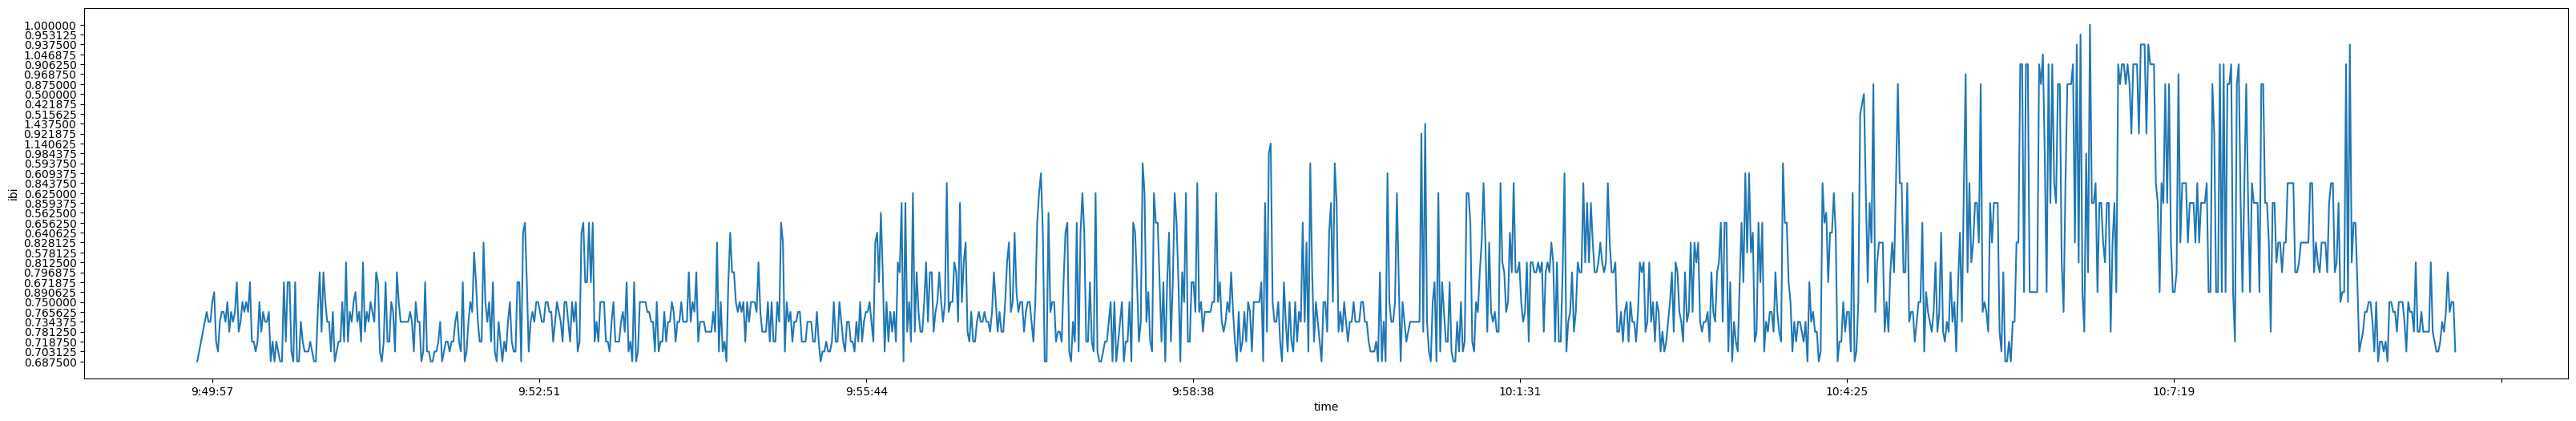

In [27]:
#plotting the ibi values
fig, a_x = plt.subplots(figsize=(40, 6))
#parameters
y=ibi_combined_data['ibi']
x=ibi_combined_data['time']
#marking time intervals
loc = mdates.MinuteLocator(interval=250000)
a_x.xaxis.set_major_locator(loc) # Locator for major axis only.
#plotting the graph
a_x.plot(x, y)
plt.xlabel('time')
plt.ylabel('ibi')

READING THE SUBJECTS BVP VALUES

In [28]:
#reading the BVP data
bvp = pd.read_csv(f'https://raw.githubusercontent.com/italha-d/Stress-Predict-Dataset/main/Raw_data/S{num}/BVP.csv',header=None)
bvp.head()

,0
0,1.646042e+09
1,6.400000e+01
2,-0.000000e+00
3,-0.000000e+00
4,-0.000000e+00


DATA ANALYSIS

In [29]:
bvp[2:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217360 entries, 2 to 217361
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       217360 non-null  float64
dtypes: float64(1)
memory usage: 1.7 MB


In [30]:
bvp[2:].describe()

,0
count,217360.000000
mean,0.012139
std,65.373559
min,-610.050000
25%,-22.880000
50%,1.060000
75%,21.210000
max,643.870000


PLOTTING THE DATA

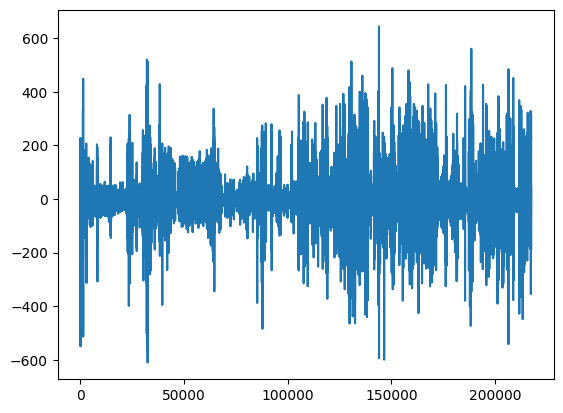

In [31]:
#plotting the graph
x = bvp[2:]
plt.plot(x)
plt.show()

In [32]:
temp = pd.read_csv(f'https://raw.githubusercontent.com/italha-d/Stress-Predict-Dataset/main/Raw_data/S{num}/TEMP.csv',header=None)
temp.head()

,0
0,1.646042e+09
1,4.000000e+00
2,3.291000e+01
3,3.291000e+01
4,3.291000e+01


In [33]:
temp_data = temp[2:]
temp_data.head()

,0
2,32.91
3,32.91
4,32.91
5,32.91
6,32.91


In [34]:
#filtering every 4th element as frequency is 4hz
count = 0
temp_4 = []
for i in temp_data[0]:
    if count % 4 == 0:
        temp_4.append(i)
    count +=1
#initital time stamp
temp_initital_time = int(temp[0][0])
#creating a pandas datafreame
temp_combined_data = pd.DataFrame()
#combining the filtered data to the dataframe
temp_combined_data['temp'] = temp_4
#creating time stamps for the rest of the data
temp_combined_data['utc_time']= range(temp_initital_time,temp_initital_time+len(temp_4))
temp_combined_data= temp_combined_data.reset_index()
temp_combined_data=temp_combined_data.drop(columns='index')
#converting UTC to 24 hr format
temp_time_stp = []
for i in  temp_combined_data['utc_time']:
    c = str(datetime.datetime.fromtimestamp(i).time())
    d = datetime.datetime.strptime(c, "%H:%M:%S")
    a =d.strftime("%I:%M:%S" )
    temp_time_stp.append(a)
    # eda_time_stp.append(f'{c.hour}:{c.minute}:{c.second}')
#combining the converted time to the dataframe
temp_combined_data['time'] = temp_time_stp

In [35]:
temp_combined_data

,temp,utc_time,time
0,32.91,1646041789,09:49:49
1,32.91,1646041790,09:49:50
2,32.93,1646041791,09:49:51
3,32.91,1646041792,09:49:52
4,32.91,1646041793,09:49:53
...,...,...,...
3389,31.95,1646045178,10:46:18
3390,31.95,1646045179,10:46:19
3391,31.99,1646045180,10:46:20
3392,31.97,1646045181,10:46:21


In [36]:
# temp_combined_data= find_index(temp_combined_data)

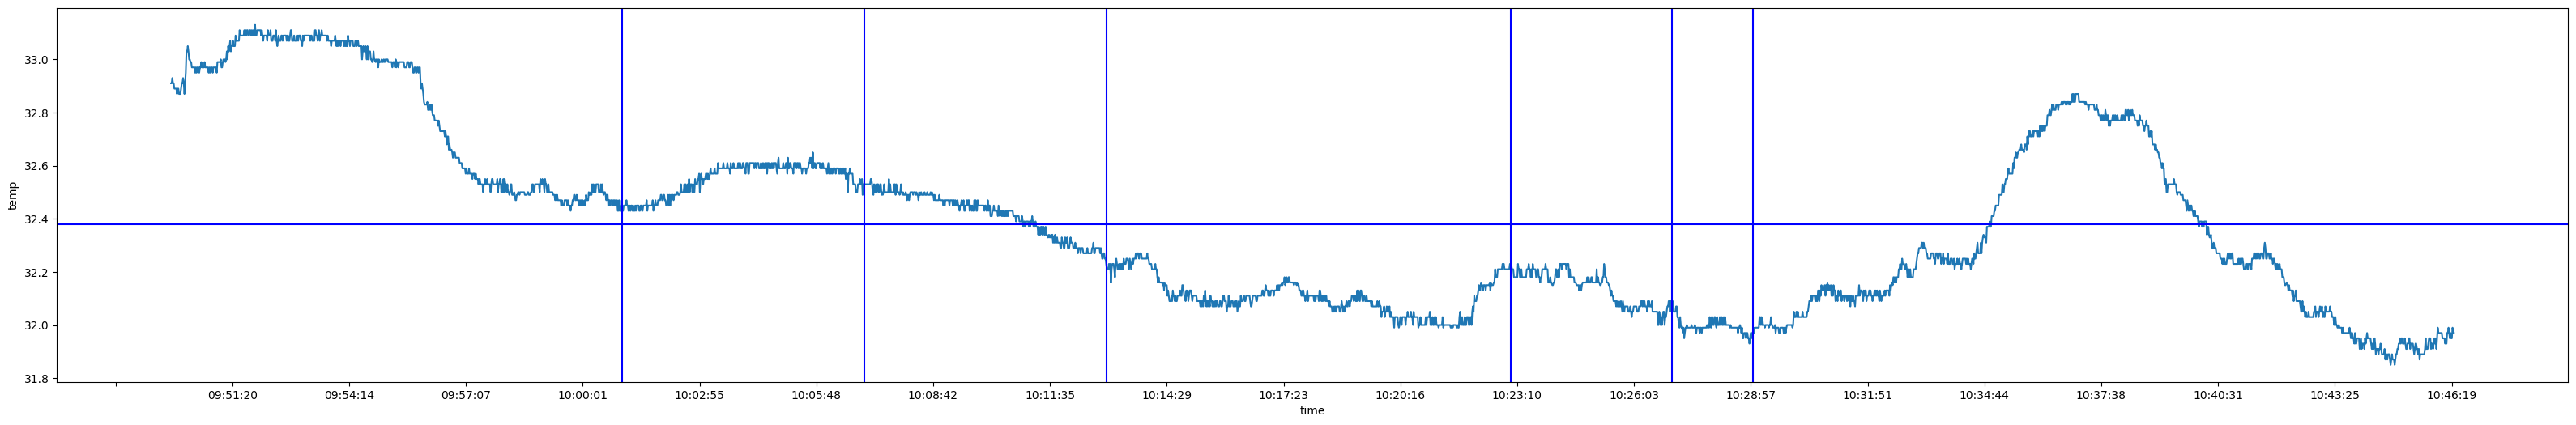

In [37]:
#plotting the eda values
fig, a_x = plt.subplots(figsize=(40, 6))
#parameters
y=temp_combined_data['temp']
x=temp_combined_data['time']
# rolling_mean_eda = y.rolling(window=200).mean()

#marking time intervals
loc = mdates.MinuteLocator(interval=250000)
a_x.xaxis.set_major_locator(loc) # Locator for major axis only.
#plotting the graph
a_x.plot(x.astype(str), y)
plt.xlabel('time')
plt.ylabel('temp')
# plt.plot(rolling_mean_eda)
for t in time_logs:
    plt.axvline(x = t, color = 'b', label = 'axvline - full height')
plt.axhline(y = y.mean(), color = 'b', label = 'axvline - full height')
#the vertical lines are the sessions and and the horizontal line respresents the mean value of the data.

READING TAG VALUES

In [38]:
tags = pd.read_csv(f'https://raw.githubusercontent.com/italha-d/Stress-Predict-Dataset/main/Raw_data/S{num}/tags_S{num}.csv',header=None)
tags.head()

,0
0,1646042441
1,1646042792
2,1646043148
3,1646043735
4,1646044029


In [39]:
# mergind the heart rate, EDA and temperature values on time
final_df = pd.merge(hr_combined_data,eda_combined_data,how='outer', on='time')

In [40]:
final_df = pd.merge(final_df,temp_combined_data,how='outer', on='time')

In [41]:
hr_combined_data.shape,eda_combined_data.shape,temp_combined_data.shape

((3386, 3), (3398, 3), (3394, 3))

In [42]:
final_df

,heart_rate,utc_time_x,time,eda,utc_time_y,temp,utc_time
0,61.00,1.646042e+09,09:49:59,0.631963,1646041799,32.89,1.646042e+09
1,68.00,1.646042e+09,09:50:00,0.619150,1646041800,32.89,1.646042e+09
2,81.67,1.646042e+09,09:50:01,0.614024,1646041801,32.87,1.646042e+09
3,81.75,1.646042e+09,09:50:02,0.610180,1646041802,32.87,1.646042e+09
4,82.00,1.646042e+09,09:50:03,0.602492,1646041803,32.87,1.646042e+09
...,...,...,...,...,...,...,...
3393,NaN,NaN,09:49:56,0.633244,1646041796,32.89,1.646042e+09
3394,NaN,NaN,09:49:57,0.637088,1646041797,32.89,1.646042e+09
3395,NaN,NaN,09:49:58,0.639651,1646041798,32.87,1.646042e+09
3396,NaN,NaN,10:46:25,1.676615,1646045185,NaN,NaN


In [43]:
# sorting the table based on index
final_df = final_df.sort_index()

In [44]:
# dropping any null values
final_df = final_df.dropna()

In [45]:
# selecting only necessary colmns
final_df= final_df[['heart_rate','eda','temp','time']]

In [46]:
e =final_df[['time']].values
e[0][0]

'09:49:59'

In [47]:
time_logs

['10:01:00', '10:07:00', '10:13:00', '10:23:00', '10:27:00', '10:29:00']

In [48]:
final_df

,heart_rate,eda,temp,time
0,61.00,0.631963,32.89,09:49:59
1,68.00,0.619150,32.89,09:50:00
2,81.67,0.614024,32.87,09:50:01
3,81.75,0.610180,32.87,09:50:02
4,82.00,0.602492,32.87,09:50:03
...,...,...,...,...
3379,88.53,1.602298,31.95,10:46:18
3380,88.47,1.593329,31.95,10:46:19
3381,88.38,1.589485,31.99,10:46:20
3382,88.27,1.645863,31.97,10:46:21


In [49]:
# labeling the stress indusing sessions as 1 and 0 for rest and baseline periosds
lable_list=[]
k =0
lable = 0
for i in e:
    if k <6:
        if str(i[0]) == time_logs[k]:
            # print('same')
            if k%2 ==0:
                lable = 1
                # print('lable',lable)
                k +=1
            else:
                lable = 0
                k +=1
    lable_list.append(lable)
    # print(i,lable)


In [50]:
final_df['lable']=lable_list

In [51]:
print(final_df.to_string())

      heart_rate       eda   temp      time  lable
0          61.00  0.631963  32.89  09:49:59      0
1          68.00  0.619150  32.89  09:50:00      0
2          81.67  0.614024  32.87  09:50:01      0
3          81.75  0.610180  32.87  09:50:02      0
4          82.00  0.602492  32.87  09:50:03      0
5          86.50  0.607618  32.89  09:50:04      0
6          90.14  0.621712  32.91  09:50:05      0
7          92.50  0.635807  32.91  09:50:06      0
8          94.56  0.733188  32.93  09:50:07      0
9          96.10  0.852352  32.91  09:50:08      0
10         97.55  0.867728  32.87  09:50:09      0
11         98.58  0.866447  32.91  09:50:10      0
12         99.31  0.834413  32.95  09:50:11      0
13         99.71  0.804943  33.03  09:50:12      0
14        100.07  0.753690  33.03  09:50:13      0
15        100.38  0.731907  33.05  09:50:14      0
16        101.29  0.717812  33.03  09:50:15      0
17        102.44  0.706280  33.00  09:50:16      0
18        103.37  0.698592  33.

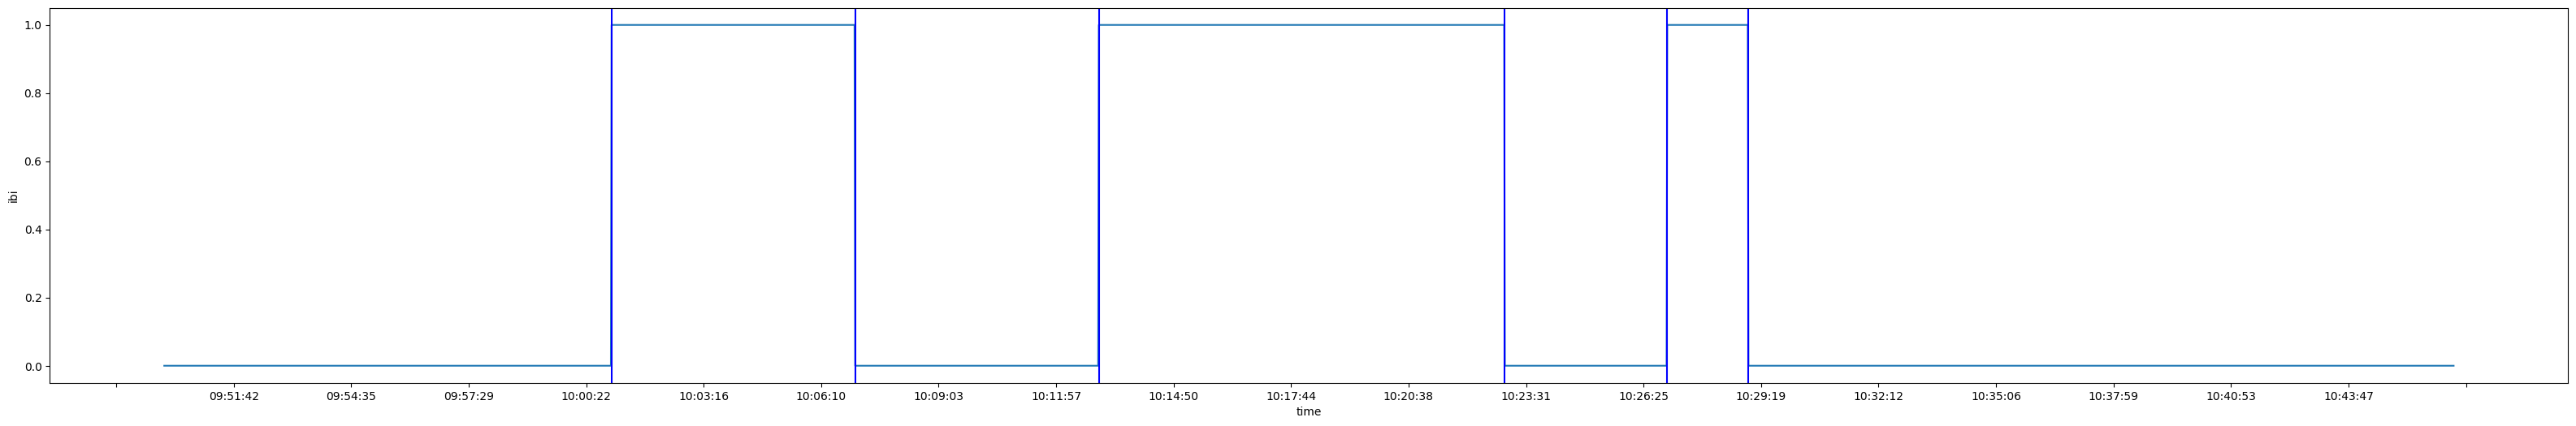

In [52]:
fig, a_x = plt.subplots(figsize=(40, 6))
#parameters
y=final_df['lable']
x=final_df['time']
#marking time intervals
loc = mdates.MinuteLocator(interval=250000)
a_x.xaxis.set_major_locator(loc) # Locator for major axis only.
#plotting the graph
# a_x.plot(x,y)
a_x.plot(x.astype(str), y)
plt.xlabel('time')
plt.ylabel('ibi')

for t in time_logs:
    plt.axvline(x = t, color = 'b', label = 'axvline - full height')

#the intervals with stressed period are marked 1 and the rest are marked 0.

In [53]:
#the summary of data when the individual is stressd.
final_df[final_df['lable']==1].describe()

,heart_rate,eda,temp,lable
count,1080.000000,1080.000000,1080.000000,1080.0
mean,89.137426,1.325764,32.242269,1.0
std,17.061462,0.197502,0.229162,0.0
min,64.550000,0.958871,31.930000,1.0
25%,80.667500,1.184065,32.070000,1.0
50%,84.850000,1.290735,32.130000,1.0
75%,91.772500,1.454746,32.500000,1.0
max,140.680000,2.321341,32.650000,1.0


In [54]:
final_df[final_df['lable']==1].mean()

/var/folders/03/h8cgljy10sjg58997m3tj9f40000gn/T/ipykernel_10157/1917165507.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  final_df[final_df['lable']==1].mean()


heart_rate    89.137426
eda            1.325764
temp          32.242269
lable          1.000000
dtype: float64

In [55]:
#the summary of data when the individual is not stressd.

final_df[final_df['lable']==0].describe()


,heart_rate,eda,temp,lable
count,2304.000000,2304.000000,2304.000000,2304.0
mean,81.222109,1.068008,32.440048,0.0
std,9.131359,0.235840,0.349685,0.0
min,61.000000,0.579498,31.850000,0.0
25%,75.865000,0.904956,32.160000,0.0
50%,80.870000,1.038264,32.430000,0.0
75%,83.490000,1.197099,32.710000,0.0
max,130.500000,2.109705,33.130000,0.0


it can be observed here that the heart rate, eda and temp values are higher during streesed period compared to the rest and baselineperiod.

In [56]:
# checkin for correlationg between the features
cor = final_df.corr()
cor

/var/folders/03/h8cgljy10sjg58997m3tj9f40000gn/T/ipykernel_10157/863279149.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = final_df.corr()


,heart_rate,eda,temp,lable
heart_rate,1.000000,0.348423,-0.117950,0.288844
eda,0.348423,1.000000,-0.512723,0.472270
temp,-0.117950,-0.512723,1.000000,-0.279939
lable,0.288844,0.472270,-0.279939,1.000000


In [57]:
final_df[['heart_rate','eda','temp']].values

array([[61.      ,  0.631963, 32.89    ],
       [68.      ,  0.61915 , 32.89    ],
       [81.67    ,  0.614024, 32.87    ],
       ...,
       [88.38    ,  1.589485, 31.99    ],
       [88.27    ,  1.645863, 31.97    ],
       [88.12    ,  1.808593, 31.97    ]])

Machine Learning Model

In [58]:
# importing the required libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [59]:
# splitting the data for training and testing purpose
X_train, X_test, y_train, y_test = train_test_split(
    final_df[['heart_rate','eda','temp']].values,final_df['lable'].values , test_size=0.3,random_state=54)

In [60]:
# standardising the data for easy computation
sc = StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.fit_transform(X_test)

In [61]:
# perforing crossvalidaion using the random forest clssifier
cv = cross_val_score(RandomForestClassifier(),X_train,y_train,cv=10)
cv.mean()

0.9645372952871345

In [62]:
# perforing crossvalidaion using the random  logistic regressor
cv = cross_val_score(LogisticRegression(),X_train,y_train,cv=10)
cv.mean()

0.7318404491167847

In [63]:
# perforing crossvalidaion using the random forest knegihbours
cv = cross_val_score(KNeighborsClassifier(),X_train,y_train,cv=10)
cv.mean()

0.9641082028177074

it can be observed that in many cases the random forest classifer performed well.

In [64]:
# creating a pipeline.
pipe = Pipeline([('scaler', StandardScaler()), ('lr', RandomForestClassifier()),])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.9537401574803149

Making predicitons

In [65]:
y_pred =pipe.predict(X_test)

Checking its performance

In [66]:
confusion_matrix(y_test,y_pred)

array([[675,  17],
       [ 30, 294]])

it can be observed that the number of time the model has predicted not stressed while the individual was actully and the number of times the model predicted that the individual was not stressed is very less.

In [67]:
accuracy_score(y_test,y_pred)

0.9537401574803149

it can be observed that the accuracy_score is consistantly above 80 percent